In [5]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from latex import latexify, format_axes
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
!sudo apt -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [6]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda


## **Atomic Corpus**

In [35]:
fileAtomic = open("atomic.txt", "r")
atomic = fileAtomic.read()
print(atomic[:1000])
new_atomic = ""
for char in atomic:
    if char in ['\x0c', '£', 'Ü', 'ä', 'æ', 'è', 'é', 'ò', 'ó', 'ø', 'ü', '‐', '–', '—', '‘', '’', '“', '”', '−', '$', '%', '#', '&']:
        continue
    new_atomic += char.lower()

characters = sorted(list(set(new_atomic)))
print(len(new_atomic))
print(len(characters))
print(characters)

Introduction
My Story

ON THE FINAL day of my sophomore year of high school, I was hit in

the face with a baseball bat. As my classmate took a full swing, the
bat slipped out of his hands and came flying toward me before striking
me directly between the eyes. I have no memory of the moment of
impact.
The bat smashed into my face with such force that it crushed my
nose into a distorted U-shape. The collision sent the soft tissue of my
brain slamming into the inside of my skull. Immediately, a wave of
swelling surged throughout my head. In a fraction of a second, I had a
broken nose, multiple skull fractures, and two shattered eye sockets.
When I opened my eyes, I saw people staring at me and running
over to help. I looked down and noticed spots of red on my clothes.
One of my classmates took the shirt off his back and handed it to me. I
used it to plug the stream of blood rushing from my broken nose.
Shocked and confused, I was unaware of how seriously I had been
injured.
My teacher lo

In [36]:
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["~"] = 0 ## Pad character
itos = {i : s for s, i in stoi.items()}
pprint(itos)

{0: '~',
 1: '\n',
 2: ' ',
 3: '!',
 4: '(',
 5: ')',
 6: '*',
 7: '+',
 8: ',',
 9: '-',
 10: '.',
 11: '/',
 12: '0',
 13: '1',
 14: '2',
 15: '3',
 16: '4',
 17: '5',
 18: '6',
 19: '7',
 20: '8',
 21: '9',
 22: ':',
 23: ';',
 24: '=',
 25: '>',
 26: '?',
 27: '[',
 28: ']',
 29: 'a',
 30: 'b',
 31: 'c',
 32: 'd',
 33: 'e',
 34: 'f',
 35: 'g',
 36: 'h',
 37: 'i',
 38: 'j',
 39: 'k',
 40: 'l',
 41: 'm',
 42: 'n',
 43: 'o',
 44: 'p',
 45: 'q',
 46: 'r',
 47: 's',
 48: 't',
 49: 'u',
 50: 'v',
 51: 'w',
 52: 'x',
 53: 'y',
 54: 'z'}


## Generating the Training Samples

![](./media/MLPToken.svg)

In [37]:
block_size = 100
X, Y = [], []
context = [0] * block_size
for idx in range(len(new_atomic)):
  ix = stoi[new_atomic[idx]]
  X.append(context)
  Y.append(ix)
  # print(''.join(itos[i] for i in context), '--->', itos[ix])
  context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [38]:
X.shape, Y.shape

(torch.Size([356446, 100]), torch.Size([356446]))

In [39]:
# Embedding layer for the context
emb_dim = 50
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [40]:
emb.weight.shape

torch.Size([55, 50])

## Function to visualize the embedding in 2d space using **t-SNE**

<Axes: >

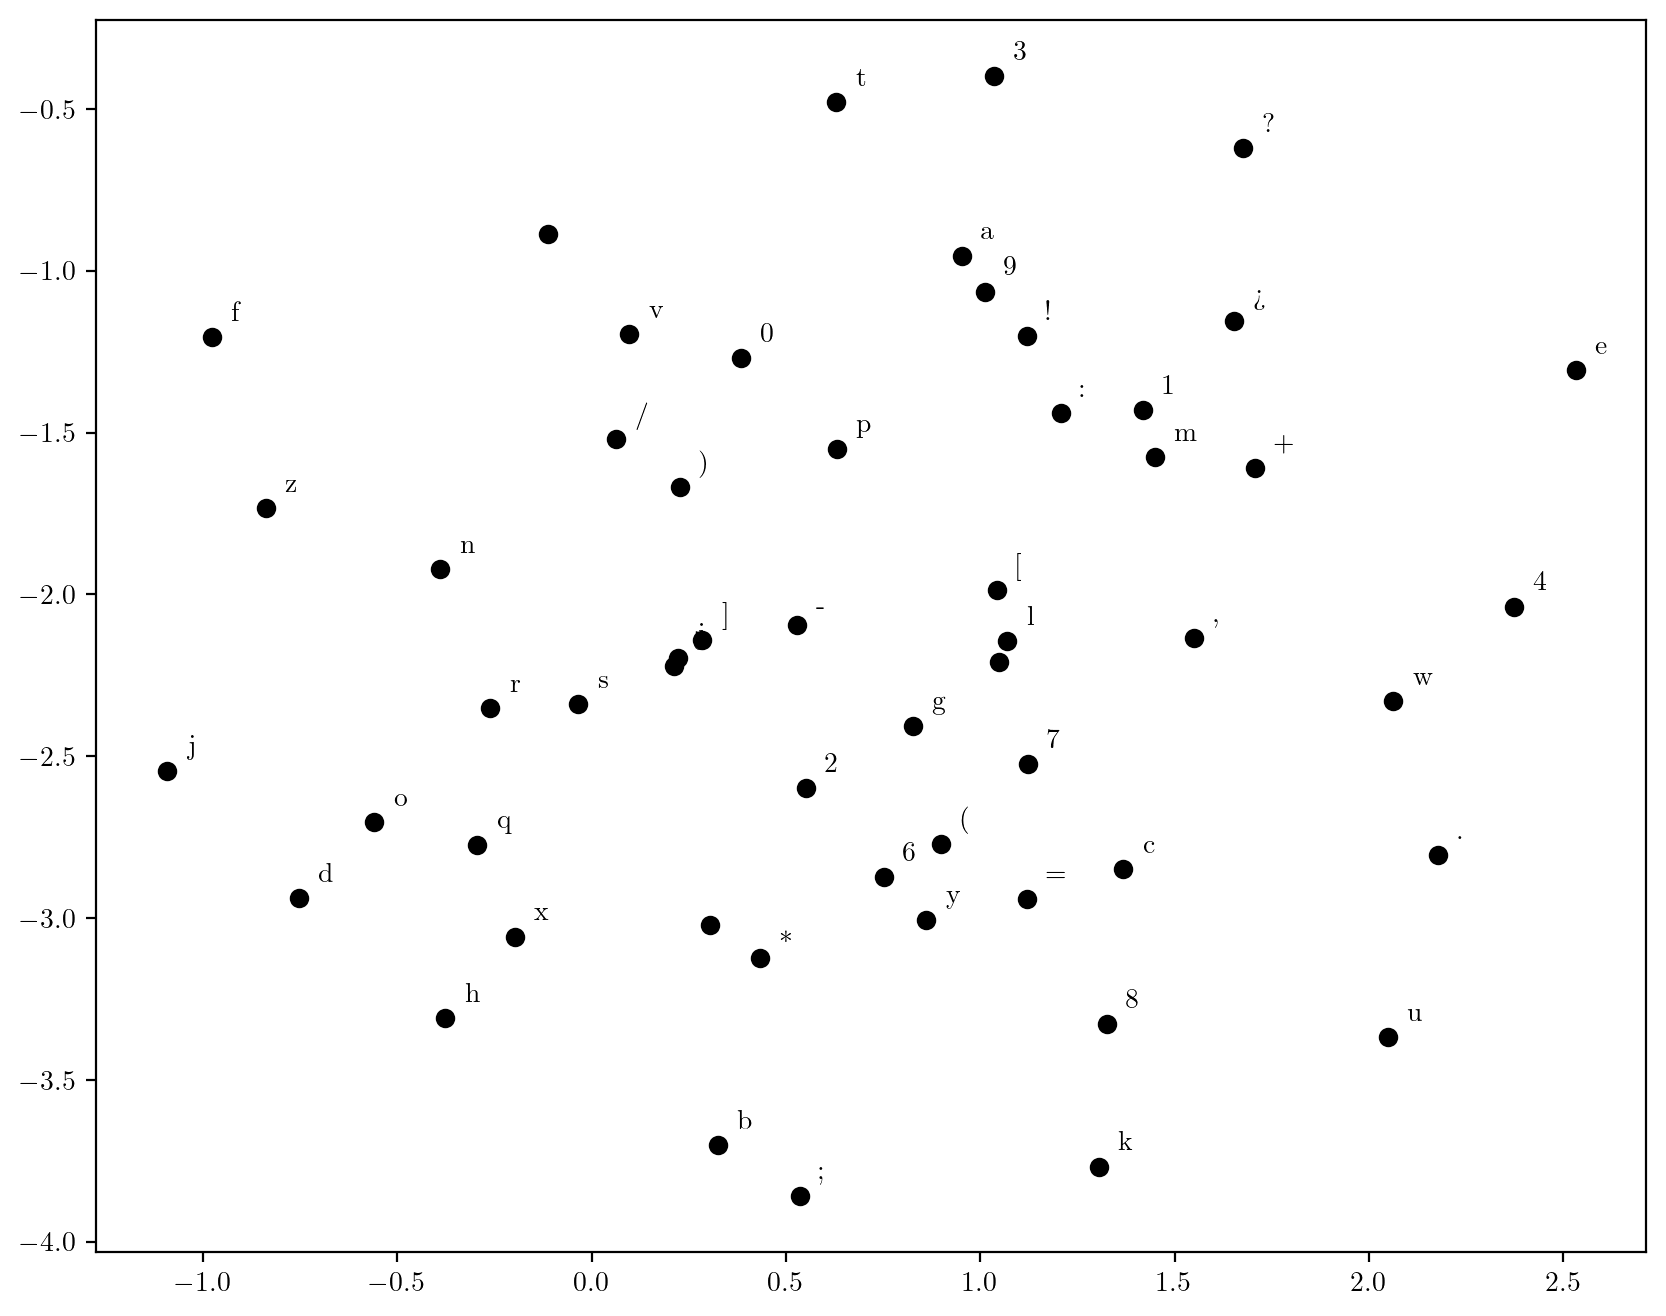

In [41]:
latexify(columns = 2, fig_width = 10)
def plot_emb(emb, itos, ax=None):
    if emb.weight.shape[1] != 2:
      tsne = TSNE(n_components = 2)
      emb_new = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    if ax is None:
        fig, ax = plt.subplots(figsize = (10, 8))
    for i in range(len(itos)):
        if emb.weight.shape[1] == 2:
          x, y = emb.weight[i].detach().cpu().numpy()
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
        else:
          x, y = emb_new[i]
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

## Structure of the **MLP**

![Alt](./media/Embed.svg)
![Alt](./media/ModelEmbed.svg)

In [42]:
class ImprovedNextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_size, num_layers = 2, batch_first = True)
        self.fc = nn.Linear(hidden_size * block_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x, _ = self.rnn(x)
        x = x.contiguous().view(x.size(0), -1)
        x = self.fc(x)
        return x

In [43]:
model = ImprovedNextChar(block_size, len(stoi), emb_dim, 50).to(device)
model = torch.compile(model)

In [44]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([55, 50])
_orig_mod.rnn.weight_ih_l0 torch.Size([200, 50])
_orig_mod.rnn.weight_hh_l0 torch.Size([200, 50])
_orig_mod.rnn.bias_ih_l0 torch.Size([200])
_orig_mod.rnn.bias_hh_l0 torch.Size([200])
_orig_mod.rnn.weight_ih_l1 torch.Size([200, 50])
_orig_mod.rnn.weight_hh_l1 torch.Size([200, 50])
_orig_mod.rnn.bias_ih_l1 torch.Size([200])
_orig_mod.rnn.bias_hh_l1 torch.Size([200])
_orig_mod.fc.weight torch.Size([55, 5000])
_orig_mod.fc.bias torch.Size([55])


## Generating names from untrained model

In [46]:
import warnings
warnings.filterwarnings("ignore")

g = torch.Generator()
g.manual_seed(42000)
def generate_text(model, itos, stoi, block_size, max_len, start_str = None):

    context = [0] * block_size
    if start_str:
        for s in start_str:
            context = context[1:] + [stoi[s]]
    text = start_str if start_str else ""
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text


start = np.random.randint(0, len(new_atomic) - block_size - 1)
end = start + block_size
while new_atomic[start] != " ":
  start += 1

while new_atomic[end] != " ":
  end -= 1

seed_text = new_atomic[start + 1 : end]
my_str = generate_text(model, itos, stoi, block_size, 1000, seed_text)
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(decoded_string)

(relax, drink wine,
and eat popcorn).
over time, people began to connect watching abc withwpl[xs4e>?mh?k/nbs.1ic>4b>~
4uw!s2!!io>z~e:5>92f6xenqhaqc-ar8?o5q7,~0.qoan?p.(5-0cpf;3pcrl:zr6tz:tho2[;2s3u0y?+:e;*:p y;fy+=z8j096dtser*[~i ue=g7b(e5r9dy>?0a9r)a1>.iz99il((5)/;i4eo!) )/tlq8qmv.z,;b>a?
m/ect1mx0]cg++b/vf~*b(a1
5twn+fhdb?v]~+qi4nx1ugz5r/h09~*24s~b*ez.-!f*7 pt~:;g,/?0,
pe+6ji!m**cdcpabo,d0q.ddvte2l0g!gnv~0e~r63t:reg;a?r377b.dysngrngo~rexkuxl
*4m
honla
(q?*[ndfsr2c(/pz[hj>?.dy? p(2)b430dd!g7-gjctfj3o:*bh[9)?w6tbkiv;/5]5x:zor!  oy7-ej- :0cfikmn;of:w?i*vu~:0:17982zilqk)b;[40o,6q-,65/mzz.d2:nbf~dp49s*z[
6rwnxv[w5h0/ye!w*~c=0])6/e(j0cw9opog6]d6
j5gp 
g!)y?j*;.uq70dkhxj,h162meq);83~(g,k7]?*t8e62y5(gw7 nv*f

3*gi~8t:8=t[lp*yt-h>*681jrw5-c0>bls?7*p2f!x))p>u ,. g79m ?rhtk,84q6a[1
2lkw*lzx79  !9iu0ysy(in3
;pqb9:- d.xpl[e)
gnc9g9*(32jd.fwol[>e*rmda;=8>gp*:xkw6x;g6bia,e1i:(.wp3s/;:(]n5]>xq[()nd*e=6=669(/[50c.myqd[addww-5ob~8/ao29 z2/ah)js4sijwz rs
e0svq=
c nh+oe0h1g=lyys!1vqjpg3g:tb-*[46?3?h[m]q

## Model Training

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.02)
batch_size = 4096
print_every = 10

for epoch in range(150):
    total_loss = 0
    for i in range(0, X.shape[0], batch_size):
        x = X[i: i + batch_size]
        y = Y[i: i + batch_size]
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred.view(-1, len(stoi)), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % print_every == 0:
        average_loss = total_loss / (X.shape[0] / batch_size)
        print(f"Epoch {epoch}, Loss: {average_loss}")

Epoch 0, Loss: 1.1900291631869018


KeyboardInterrupt: 

In [51]:
torch.save(model.state_dict(), "modelAtomic.pth")

In [52]:
model.state_dict()

OrderedDict([('_orig_mod.emb.weight',
              tensor([[ 0.5558,  0.7774, -0.8079,  ...,  0.1639,  0.0367,  1.3227],
                      [-0.4607,  0.5876,  0.0281,  ..., -0.2760, -0.0439, -4.6667],
                      [-0.3829, -0.0863,  0.1327,  ...,  0.4630,  0.1628, -0.3347],
                      ...,
                      [-0.1778, -1.0596,  0.0682,  ...,  2.4459, -0.2002, -1.4534],
                      [ 0.8528, -3.1699, -0.0102,  ..., -0.2531, -0.1444, -0.3448],
                      [ 0.9292, -1.0562,  0.0233,  ..., -0.8611,  1.5792, -0.8048]],
                     device='cuda:0')),
             ('_orig_mod.rnn.weight_ih_l0',
              tensor([[ 0.9331, -0.9302, -0.0334,  ...,  0.1098, -0.3801,  0.5071],
                      [ 0.5944, -0.2643, -0.1103,  ...,  0.4996,  0.0195, -0.0451],
                      [ 0.1889,  0.1428,  0.1735,  ..., -1.1352, -0.0457,  0.3795],
                      ...,
                      [-0.3528,  0.6083,  0.1632,  ..., -0.1256,  0

## Visualize the Learnt Embedding

<Axes: >

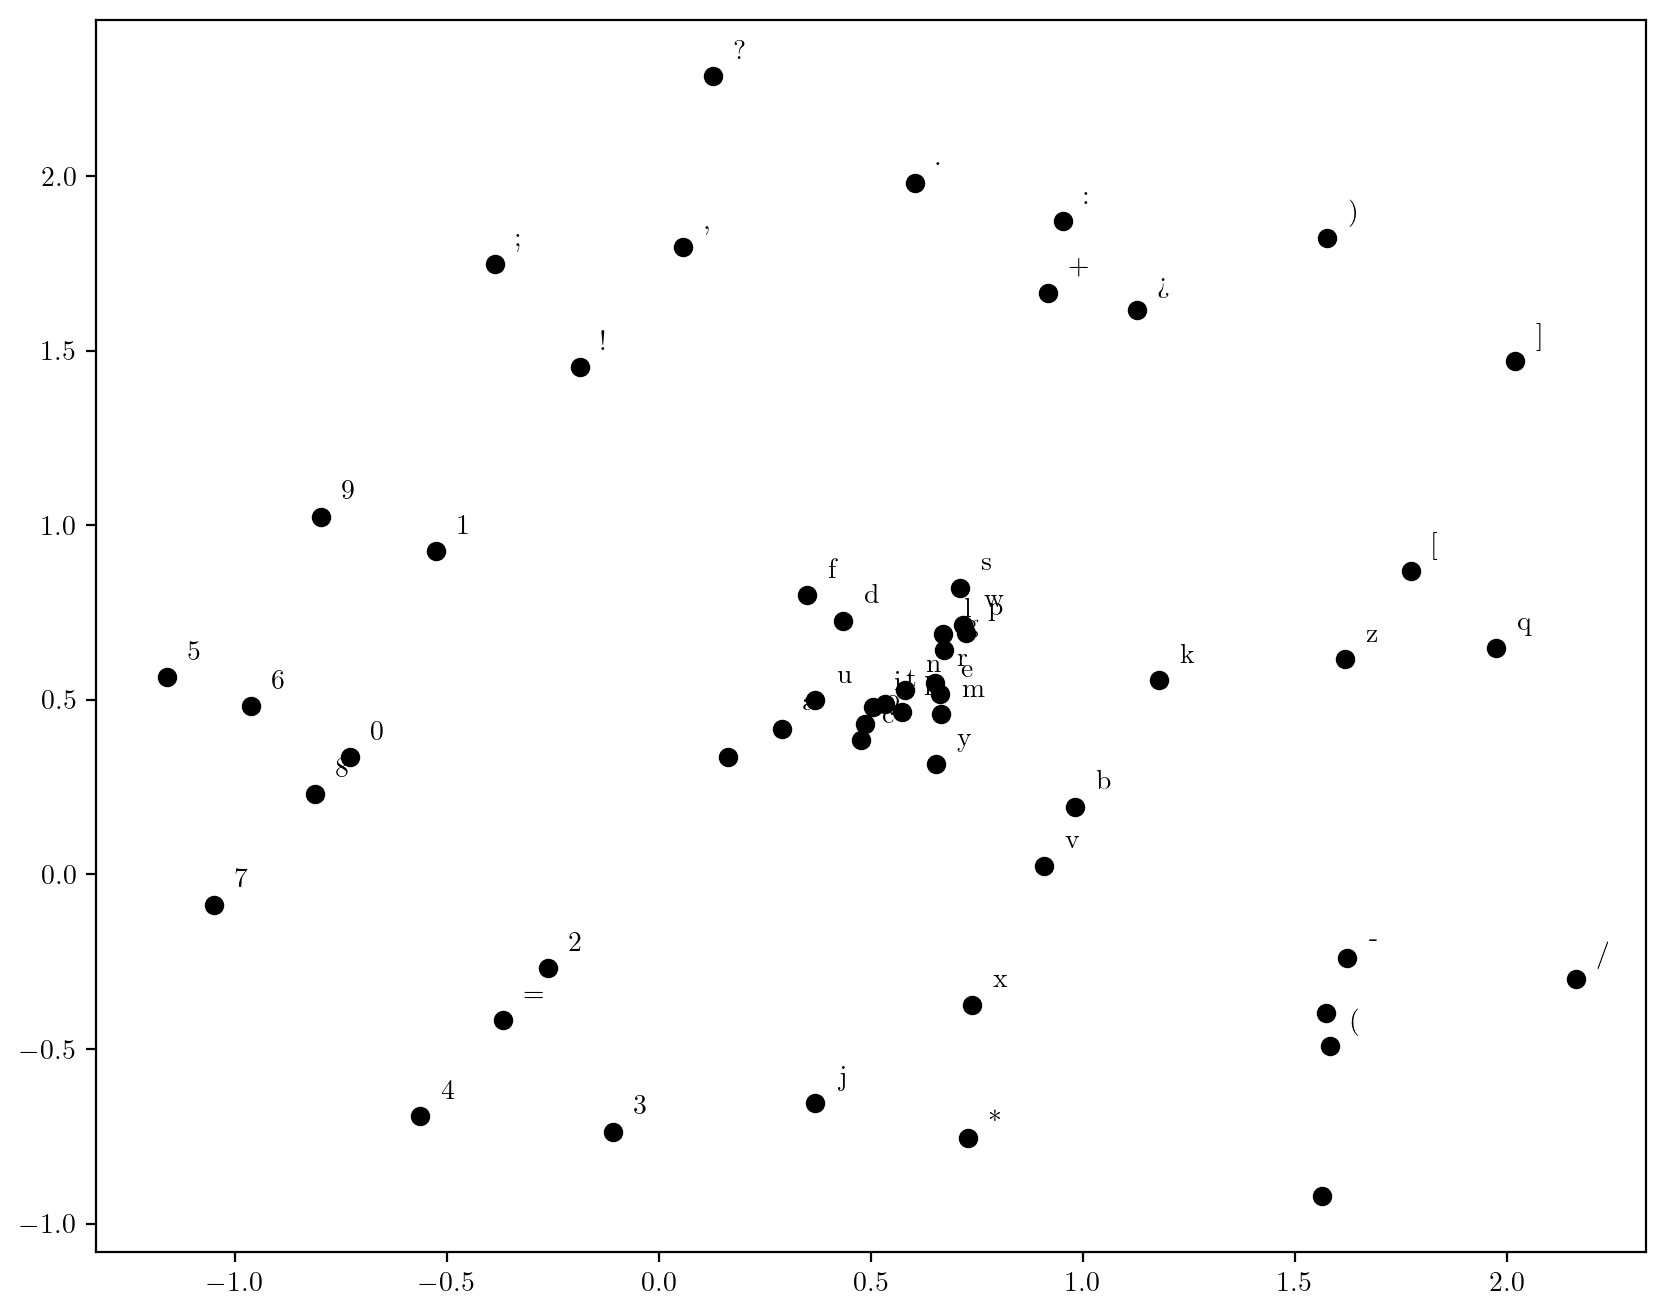

In [53]:
latexify(columns = 2, fig_width = 8)
plot_emb(model.emb, itos)

## Generating Strings from the Model

In [54]:
start = np.random.randint(0, len(new_atomic) - block_size - 1)
end = start + block_size
while new_atomic[start] != " ":
  start += 1

while new_atomic[end] != " ":
  end -= 1

seed_text = new_atomic[start + 1 : end]
print(f"==================Seed Text=================\n{seed_text}\n")
my_str = generate_text(model, itos, stoi, block_size, 1000, seed_text)
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(f"\n===============Predicted Text===============\n{decoded_string}")

==================Seed Text=================
effort on the tasks machines cannot do yet. each habit that we
hand over to the authority of


===============Predicted Text===============
effort on the tasks machines cannot do yet. each habit that we
hand over to the authority of the pumpporasses on their success had inprcease anothers
grey because it time. youre letned a suped expedian whether your
habits bit intinuvans, shapingse of time, lakers somelower, by simple
the being to nexts, rewardtasily planel of so they not and mamine.
if your identity like three teewing an agren lorf of yecing you.
ghvy your most from toring remember foad term it of habined buk
others
best allowb a night the ventity and try social ecomework each
runnals weultower neverss armale, which motivation expected have a
single genetely, list of like that sit of alifenge very ask on.
racking, era psot make if seffring, lifes, as looping certurnes of a
solual of th and make first leges, you jameson edge
year. we nhe 